In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_dosya_yolu = "/content/drive/MyDrive/MURA-v1.1.zip"
hedef_klasor = "/content/unziped_mura/"
print(f"\n'{hedef_klasor}' hazırlanıyor...")
!rm -rf "{hedef_klasor}"
!mkdir -p "{hedef_klasor}"
!unzip -n "{zip_dosya_yolu}" -d "{hedef_klasor}"
print("\nUnzip komutu tamamlandı.")
print(f"\n'{hedef_klasor}' içeriği:")
!ls -l "{hedef_klasor}"

Streaming output truncated to the last 5000 lines.
   creating: /content/unziped_mura/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/
  inflating: /content/unziped_mura/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image1.png  
  inflating: /content/unziped_mura/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image3.png  
  inflating: /content/unziped_mura/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image2.png  
   creating: /content/unziped_mura/MURA-v1.1/train/XR_SHOULDER/patient01182/
   creating: /content/unziped_mura/MURA-v1.1/train/XR_SHOULDER/patient01182/study1_positive/
  inflating: /content/unziped_mura/MURA-v1.1/train/XR_SHOULDER/patient01182/study1_positive/image1.png  
  inflating: /content/unziped_mura/MURA-v1.1/train/XR_SHOULDER/patient01182/study1_positive/image3.png  
  inflating: /content/unziped_mura/MURA-v1.1/train/XR_SHOULDER/patient01182/study1_positive/image2.png  
   creating: /content/unziped_mura/MURA-v1.1/train/XR_SH

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import random


In [ ]:
main_dir = "/content/unziped_mura/"
train_path = os.path.join(main_dir, "/content/unziped_mura/MURA-v1.1/train_image_paths.csv")

train_df = pd.read_csv(train_path, header=None, names=['image_path'])
train_df['full_path'] = train_df['image_path'].apply(lambda path: os.path.join(main_dir, path))
train_df['label'] = train_df['image_path'].apply(lambda path: 1 if 'positive' in path else 0)

print("Toplam eğitim görüntüsü:",len(train_df))
print("Label Dağılımı:\n",train_df['label'].value_counts())

Toplam eğitim görüntüsü: 36808
Label Dağılımı:
 label
0    21935
1    14873
Name: count, dtype: int64


In [ ]:
valid_path = os.path.join(main_dir, "/content/unziped_mura/MURA-v1.1/valid_image_paths.csv")

valid_df = pd.read_csv(valid_path, header=None, names=['image_path'])
valid_df['full_path'] = valid_df['image_path'].apply(lambda path: os.path.join(main_dir, path))
valid_df['label'] = valid_df['image_path'].apply(lambda path: 1 if 'positive' in path else 0)

print("Toplam doğrulama görüntüsü:",len(valid_df))
print("Label Dağılımı:\n",valid_df['label'].value_counts())

Toplam doğrulama görüntüsü: 3197
Label Dağılımı:
 label
0    1667
1    1530
Name: count, dtype: int64


In [ ]:
import tensorflow as tf

ımageSize = (224,224)
batchSize = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_df['label'] = train_df['label'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'full_path',
    y_col = 'label',
    target_size = ımageSize,
    batch_size = batchSize,
    class_mode = 'binary',
    shuffle = True
)
valid_df['label'] = valid_df['label'].astype(str)
validation_generator = valid_datagen.flow_from_dataframe(
    dataframe = valid_df,
    x_col = 'full_path',
    y_col = 'label',
    target_size = ımageSize,
    batch_size = batchSize,
    class_mode = 'binary',
    shuffle = False
)
sample_images,sample_labels = next(train_generator)
print(f"Sample images shape: {sample_images.shape}")
print(f"Sample labels shape: {sample_labels.shape}")

Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.
Sample images shape: (32, 224, 224, 3)
Sample labels shape: (32,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Model Mimarisi
model_custom = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Modeli Derleme
print("ÖZEL CNN MODELİ DERLENİYOR...")
model_custom.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

model_custom.summary()

# Modeli Eğitme
EPOCHS = 20
print(f"\nÖZEL CNN MODELİ {EPOCHS} EPOCH BOYUNCA EĞİTİLİYOR...")
history_custom = model_custom.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

# Modeli Değerlendirme
print("\nÖZEL CNN MODELİ DEĞERLENDİRİLİYOR...")
scores_custom = model_custom.evaluate(validation_generator)
print("-" * 50)
print(f"Özel CNN - Nihai Doğruluk: {scores_custom[1] * 100:.2f}%")
print(f"Özel CNN - Nihai Kayıp: {scores_custom[0]}")
print("-" * 50)

#Epoch = 2 %52.89
#Epoch = 20 %64.50

ÖZEL CNN MODELİ DERLENİYOR...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)


ÖZEL CNN MODELİ 20 EPOCH BOYUNCA EĞİTİLİYOR...
Epoch 1/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 492s 423ms/step - accuracy: 0.5885 - loss: 0.6825 - val_accuracy: 0.5214 - val_loss: 0.7104
Epoch 2/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 486s 422ms/step - accuracy: 0.5947 - loss: 0.6679 - val_accuracy: 0.5214 - val_loss: 0.6972
Epoch 3/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 487s 423ms/step - accuracy: 0.5986 - loss: 0.6651 - val_accuracy: 0.5267 - val_loss: 0.6823
Epoch 4/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 418ms/step - accuracy: 0.5958 - loss: 0.6596 - val_accuracy: 0.5358 - val_loss: 0.6780
Epoch 5/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 483s 420ms/step - accuracy: 0.5925 - loss: 0.6582 - val_accuracy: 0.5493 - val_loss: 0.6762
Epoch 6/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 485s 421ms/step - accuracy: 0.5987 - loss: 0.6536 - val_accuracy: 0.5346 - val_loss: 0.6767
Epoch 7/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 484s 420ms/step - accuracy: 0.5999 - loss: 0.6528 - val_accuracy: 0.5333 - val_loss: 0.6897
Epoch 8/20
115

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import matplotlib.pyplot as plt

base_model = ResNet50V2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = True

# Yeni Modeli Oluşturma
model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
fine_tune_at = 140
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Modeli Derleme
print("TRANSFER ÖĞRENME (ResNet50V2) MODELİ DERLENİYOR...")
model_resnet.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

optimizer_fine_tune = tf.keras.optimizers.Adam(learning_rate=1e-5) # 0.00001
model_resnet.compile(loss='binary_crossentropy',
                     optimizer=optimizer_fine_tune,
                     metrics=['accuracy'])

FINE_TUNE_EPOCHS = 20
TOTAL_EPOCHS = 20 + FINE_TUNE_EPOCHS

history_fine_tune = model_resnet.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=20,
    validation_data=validation_generator
)

print("İNCE AYAR İÇİN MODEL YENİDEN DERLENDİ.")
model_resnet.summary()


# Modeli Eğitme
EPOCHS = 20
print(f"\nTRANSFER ÖĞRENME MODELİ {EPOCHS} EPOCH BOYUNCA EĞİTİLİYOR...")
history_resnet = model_resnet.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

# Modeli Değerlendirme
print("\nTRANSFER ÖĞRENME MODELİ DEĞERLENDİRİLİYOR...")
scores_resnet = model_resnet.evaluate(validation_generator)
print("-" * 50)
print(f"Transfer Öğrenme - Nihai Doğruluk: {scores_resnet[1] * 100:.2f}%")
print(f"Transfer Öğrenme - Nihai Kayıp: {scores_resnet[0]}")
print("-" * 50)

# Epoch = 15 %72.69 Basic
# Epoch = 20 %80.26

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
TRANSFER ÖĞRENME (ResNet50V2) MODELİ DERLENİYOR...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 21/40
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 521s 430ms/step - accuracy: 0.6001 - loss: 0.6783 - val_accuracy: 0.7322 - val_loss: 0.5533
Epoch 22/40
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 484s 421ms/step - accuracy: 0.7329 - loss: 0.5383 - val_accuracy: 0.7566 - val_loss: 0.5065
Epoch 23/40
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 482s 419ms/step - accuracy: 0.7670 - loss: 0.5000 - val_accuracy: 0.7682 - val_loss: 0.4929
Epoch 24/40
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 483s 420ms/step - accuracy: 0.7790 - loss: 0.4819 - val_accuracy: 0.7779 - val_loss: 0.4845
Epoch 25/40
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 484s 421ms/step - accuracy: 0.7918 - loss: 0.4647 - val_accuracy: 0.7839 - val_loss: 0.4885
Epoch 26/40
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 418ms/step - accuracy: 0.7974 - loss: 0.4524 - val_accuracy: 0.7829 - val_loss: 0.4782
Epoch 27/40
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 483s 419ms/step - accuracy: 0.7990 - loss: 0.4461 - val_accuracy: 0.7904 - val_loss: 0.4777
Epoch 28/40
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 482s 419ms/s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,056,517 (217.65 MB)

 Trainable params: 16,614,657 (63.38 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

 Optimizer params: 33,229,316 (126.76 MB)


TRANSFER ÖĞRENME MODELİ 20 EPOCH BOYUNCA EĞİTİLİYOR...
Epoch 1/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 482s 419ms/step - accuracy: 0.8572 - loss: 0.3322 - val_accuracy: 0.7976 - val_loss: 0.5409
Epoch 2/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 485s 421ms/step - accuracy: 0.8591 - loss: 0.3257 - val_accuracy: 0.7948 - val_loss: 0.5685
Epoch 3/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 484s 420ms/step - accuracy: 0.8622 - loss: 0.3193 - val_accuracy: 0.8017 - val_loss: 0.5535
Epoch 4/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 418ms/step - accuracy: 0.8638 - loss: 0.3181 - val_accuracy: 0.8039 - val_loss: 0.5631
Epoch 5/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 483s 420ms/step - accuracy: 0.8625 - loss: 0.3163 - val_accuracy: 0.8045 - val_loss: 0.5858
Epoch 6/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 480s 417ms/step - accuracy: 0.8660 - loss: 0.3045 - val_accuracy: 0.7936 - val_loss: 0.6178
Epoch 7/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 483s 419ms/step - accuracy: 0.8711 - loss: 0.2998 - val_accuracy: 0.7936 - val_loss: 0.6248
Epoch 

In [ ]:
base_model.trainable = True

fine_tune_at = 140


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# --- Modeli Daha Düşük Bir Öğrenme Oranıyla Tekrar Derleme ---
optimizer_fine_tune = tf.keras.optimizers.Adam(learning_rate=1e-5) # 0.00001
model_resnet.compile(loss='binary_crossentropy',
                     optimizer=optimizer_fine_tune,
                     metrics=['accuracy'])

print("\nİNCE AYAR İÇİN MODEL YENİDEN DERLENDİ. EĞİTİM BAŞLIYOR...")
model_resnet.summary()

# --- İnce Ayar Eğitimini Başlatma ---
FINE_TUNE_EPOCHS = 20
TOTAL_EPOCHS = EPOCHS + FINE_TUNE_EPOCHS

# Eğitime kaldığı yerden devam ediyoruz.
history_fine_tune = model_resnet.fit(train_generator,
                                     epochs=TOTAL_EPOCHS,
                                     initial_epoch=history_resnet.epoch[-1], # Önceki eğitimin son epoch'undan başla
                                     validation_data=validation_generator,
                                     steps_per_epoch=len(train_generator),
                                     validation_steps=len(validation_generator))

# --- Modeli Değerlendirme ---
print("\nİNCE AYAR YAPILMIŞ MODEL DEĞERLENDİRİLİYOR...")
scores_fine_tune = model_resnet.evaluate(validation_generator)
print("-" * 50)
print(f"İnce Ayar Sonrası Nihai Doğruluk: {scores_fine_tune[1] * 100:.2f}%")
print(f"İnce Ayar Sonrası Nihai Kayıp: {scores_fine_tune[0]}")
print("-" * 50)

NameError: name 'base_model' is not defined

Veri Üreteçleri Oluşturuluyor...
Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.
--- Model Özeti (Özellik Çıkarım Aşaması) ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,089,601 (91.89 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)


Model 15 epoch boyunca (sadece üst katmanlar) eğitiliyor...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 507s 431ms/step - accuracy: 0.6575 - loss: 0.6477 - val_accuracy: 0.6953 - val_loss: 0.5800
Epoch 2/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 486s 422ms/step - accuracy: 0.7111 - loss: 0.5684 - val_accuracy: 0.6835 - val_loss: 0.5881
Epoch 3/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 486s 422ms/step - accuracy: 0.7188 - loss: 0.5583 - val_accuracy: 0.7222 - val_loss: 0.5442
Epoch 4/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 483s 420ms/step - accuracy: 0.7258 - loss: 0.5485 - val_accuracy: 0.7319 - val_loss: 0.5365
Epoch 5/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 475s 412ms/step - accuracy: 0.7329 - loss: 0.5433 - val_accuracy: 0.7301 - val_loss: 0.5417
Epoch 6/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 476s 414ms/step - accuracy: 0.7343 - loss: 0.5395 - val_accuracy: 0.7241 - val_loss: 0.5451
Epoch 7/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 477s 415ms/step - accuracy: 0.7344 - loss: 0.5392 - val_accuracy: 0.7307 - val_loss: 0.5325
Epoch 8/15
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 477s 414ms/step - ac

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,089,601 (91.89 MB)

 Trainable params: 16,877,057 (64.38 MB)

 Non-trainable params: 7,212,544 (27.51 MB)


Model 15 epoch daha (ince ayar) eğitiliyor...
Epoch 15/30
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 518s 431ms/step - accuracy: 0.7127 - loss: 0.5617 - val_accuracy: 0.7426 - val_loss: 0.5273 - learning_rate: 1.0000e-05
Epoch 16/30
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 487s 423ms/step - accuracy: 0.7627 - loss: 0.5053 - val_accuracy: 0.7607 - val_loss: 0.5245 - learning_rate: 1.0000e-05
Epoch 17/30
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 488s 424ms/step - accuracy: 0.7851 - loss: 0.4718 - val_accuracy: 0.7754 - val_loss: 0.4984 - learning_rate: 1.0000e-05
Epoch 18/30
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 483s 420ms/step - accuracy: 0.7941 - loss: 0.4521 - val_accuracy: 0.7789 - val_loss: 0.4879 - learning_rate: 1.0000e-05
Epoch 19/30
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 488s 424ms/step - accuracy: 0.7979 - loss: 0.4420 - val_accuracy: 0.7770 - val_loss: 0.5262 - learning_rate: 1.0000e-05
Epoch 20/30
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 485s 421ms/step - accuracy: 0.8114 - loss: 0.4222 - val_accuracy: 0.7842 - val_loss: 0.5032 - l

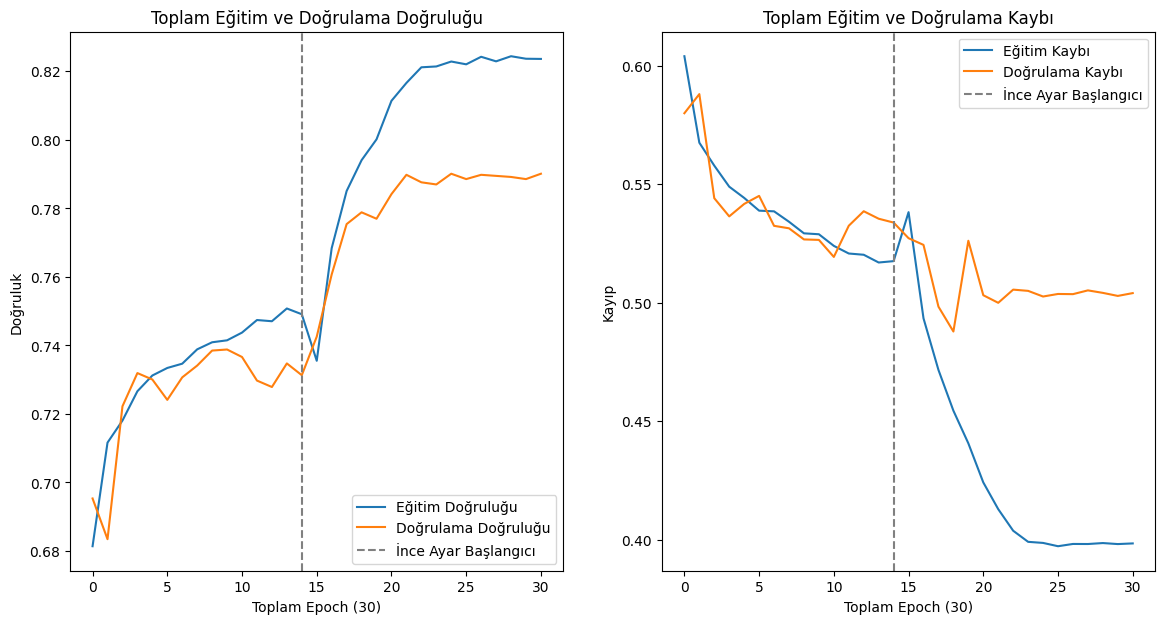

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt



IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)


valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

print("Veri Üreteçleri Oluşturuluyor...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='full_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='full_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# --- 2. ADIM: TRANSFER ÖĞRENME MODELİNİ KURMA (ÖZELLİK ÇIKARIM AŞAMASI) ---
# Önceden eğitilmiş ResNet50V2 modelini yüklüyoruz.
base_model = ResNet50V2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# Temel modelin ağırlıklarını donduruyoruz.
base_model.trainable = False

# Yeni modeli oluşturuyoruz.
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'), # Nöron sayısını biraz artırabiliriz.
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Modeli standart bir öğrenme oranıyla derliyoruz.
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("--- Model Özeti (Özellik Çıkarım Aşaması) ---")
model.summary()


# --- 3. ADIM: İLK EĞİTİM (SADECE ÜST KATMANLAR) ---
INITIAL_EPOCHS = 15
print(f"\nModel {INITIAL_EPOCHS} epoch boyunca (sadece üst katmanlar) eğitiliyor...")

history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator
)

# --- 4. ADIM: İNCE AYAR (FINE-TUNING) AŞAMASI ---
print("\n--- İnce Ayar (Fine-Tuning) Aşaması Başlıyor ---")

# Temel modelin kilidini açıyoruz.
base_model.trainable = True

# Sadece son katman bloklarını eğiteceğiz.
fine_tune_at = 140
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Modeli ÇOK DÜŞÜK bir öğrenme oranıyla yeniden derliyoruz.
model.compile(optimizer=Adam(learning_rate=1e-5), # 0.00001
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\n--- Model Özeti (İnce Ayar Aşaması) ---")
model.summary() # Eğitilebilir parametre sayısının arttığına dikkat et.


# --- 5. ADIM: İNCE AYAR EĞİTİMİ ---
FINE_TUNE_EPOCHS = 15
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# Öğrenme oranını, doğrulama kaybı (val_loss) iyileşmediğinde düşüren callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

print(f"\nModel {FINE_TUNE_EPOCHS} epoch daha (ince ayar) eğitiliyor...")
history_fine_tune = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1], # Eğitime kaldığı yerden devam et
    validation_data=validation_generator,
    callbacks=[reduce_lr] # Callback'i burada ekliyoruz
)


# --- 6. ADIM: NİHAİ DEĞERLENDİRME VE GÖRSELLEŞTİRME ---
print("\nİnce ayar sonrası nihai model performansı değerlendiriliyor...")
scores = model.evaluate(validation_generator)
print("-" * 50)
print(f"İNCE AYAR SONRASI DOĞRULUK: {scores[1] * 100:.2f}%")
print(f"İNCE AYAR SONRASI KAYIP: {scores[0]}")
print("-" * 50)

# Her iki eğitim sürecinin geçmişini birleştirelim
acc = history.history['accuracy'] + history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
loss = history.history['loss'] + history_fine_tune.history['loss']
val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']

# Grafiği çizdirelim
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Eğitim Doğruluğu')
plt.plot(val_acc, label='Doğrulama Doğruluğu')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='İnce Ayar Başlangıcı')
plt.legend(loc='lower right')
plt.title('Toplam Eğitim ve Doğrulama Doğruluğu')
plt.xlabel(f'Toplam Epoch ({TOTAL_EPOCHS})')
plt.ylabel('Doğruluk')


plt.subplot(1, 2, 2)
plt.plot(loss, label='Eğitim Kaybı')
plt.plot(val_loss, label='Doğrulama Kaybı')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='İnce Ayar Başlangıcı')
plt.legend(loc='upper right')
plt.title('Toplam Eğitim ve Doğrulama Kaybı')
plt.xlabel(f'Toplam Epoch ({TOTAL_EPOCHS})')
plt.ylabel('Kayıp')

plt.show()